<a href="https://colab.research.google.com/github/linneverh/ML/blob/linne/Kaggle_Recommenders_V1_Linne_User%20Based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import random


# Recommender Systems

#### Step 1: Load the Data

We’ll start by loading the datasets in the `data` folder. We have 3 datasets here:
- `interactions.csv`
- `items.csv`


In [2]:
# Load the datasets
interactions = pd.read_csv('https://raw.githubusercontent.com/linneverh/MachineLearning/main/interactions_train.csv')
items = pd.read_csv("https://raw.githubusercontent.com/linneverh/MachineLearning/main/items.csv")

# Display the first rows of each dataset
display(interactions.head())
display(items.head())

,u,i,t
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


In [3]:
# Rename columns in the interactions DataFrame
interactions = interactions.rename(columns={'u': 'user_id', 'i': 'book_id', 't': 'timestamp'})
items=items.rename(columns={'i':'book_id'})
# Display the first rows of the updated interactions DataFrame
display(interactions.head())
display(items.head())


,user_id,book_id,timestamp
0,4456,8581,1.687541e+09
1,142,1964,1.679585e+09
2,362,3705,1.706872e+09
3,1809,11317,1.673533e+09
4,4384,1323,1.681402e+09


,Title,Author,ISBN Valid,Publisher,Subjects,book_id
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4



#### Step 2: Check the Number of interactions, users and movies

Let’s check how many unique users and items we have in this dataset.

In [4]:
n_users = interactions.user_id.nunique()
n_items = items.book_id.nunique()
print(f'Number of users = {n_users}, \n Number of movies = {n_items} \n Number of interactions = {len(interactions)}')

Number of users = 7838, 
 Number of movies = 15291 
 Number of interactions = 87047


In [5]:
n_items = items.book_id.nunique()
print(f'Number of books = {n_items}')

Number of books = 15291


###Train - Test splitting

In [6]:
# let's first sort the interactions by user and time stamp
interactions = interactions.sort_values(["user_id", "timestamp"])
interactions.head(10)

,user_id,book_id,timestamp
21035,0,0,1.680191e+09
28842,0,1,1.680783e+09
3958,0,2,1.680801e+09
29592,0,3,1.683715e+09
6371,0,3,1.683715e+09
41220,0,4,1.686569e+09
12217,0,5,1.687014e+09
19703,0,6,1.687014e+09
64522,0,7,1.687014e+09
29380,0,8,1.687260e+09


Next we can use the percentage rank from pandas to get a proportional ranking of the timestamps for each user. Check the documentation on how to use the `rank` funciton with groupby in pandas (https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.rank.html#pandas.core.groupby.DataFrameGroupBy.rank).

In [7]:
interactions["pct_rank"] = interactions.groupby("user_id")["timestamp"].rank(pct=True, method='dense')
interactions.reset_index(inplace=True, drop=True)
interactions.head(10)

,user_id,book_id,timestamp,pct_rank
0,0,0,1.680191e+09,0.04
1,0,1,1.680783e+09,0.08
2,0,2,1.680801e+09,0.12
3,0,3,1.683715e+09,0.16
4,0,3,1.683715e+09,0.20
5,0,4,1.686569e+09,0.24
6,0,5,1.687014e+09,0.28
7,0,6,1.687014e+09,0.32
8,0,7,1.687014e+09,0.36
9,0,8,1.687260e+09,0.40


Now all remains to do is to pick the first 80% of the interactions of each user in the training set and the rest in the test set. We can do so using the `pct_rank` column.

In [8]:
train_data = interactions[interactions["pct_rank"] < 0.8]
test_data = interactions[interactions["pct_rank"] >= 0.8]

In [9]:
print("Training set size:", train_data.shape[0])
print("Testing set size:", test_data.shape[0])

Training set size: 65419
Testing set size: 21628


## Task 2: Creating User-Item Matrices for Implicit Feedback


In [10]:
print('number of users =', n_users, '| number of movies =', n_items)

number of users = 7838 | number of movies = 15291


#### Step 1: Define the Function to Create the Data Matrix

Next, we’ll define a function that creates the user-item data matrix. Each matrix cell will contain a 1 if there was an interaction and a 0 otherwise.


In [32]:
# Define a function to create the data matrix
def create_data_matrix(data, n_users, n_items):
    """
    This function returns a numpy matrix with shape (n_users, n_items).
    Each entry is a binary value indicating positive interaction.
    """
    data_matrix = np.zeros((n_users, n_items))
    data_matrix[data["user_id"].values, data["book_id"].values] = 1
    return data_matrix

#### Step 2: Create the Training and Testing Matrices

Now we can use the function to create matrices for both the training and testing data. Each cell in the matrix will show a 1 if there was a positive interaction in the training or testing data, and a 0 otherwise.

In [36]:
# Create the training and testing matrices
train_data_matrix = create_data_matrix(interactions, n_users, n_items)
test_data_matrix = create_data_matrix(interactions, n_users, n_items)

# Display the matrices to understand their structure
print('train_data_matrix')
print(train_data_matrix)
print("number of non-zero values: ", np.sum(train_data_matrix))
print('test_data_matrix')
print(test_data_matrix)
print("number of non-zero values: ", np.sum(test_data_matrix))


train_data_matrix
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
number of non-zero values:  64003.0
test_data_matrix
[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
number of non-zero values:  64003.0


In [37]:
#give the dimensions of matrices

print("Train data matrix dimensions:", train_data_matrix.shape)
print("Test data matrix dimensions:", test_data_matrix.shape)

Train data matrix dimensions: (7838, 15291)
Test data matrix dimensions: (7838, 15291)


#### Step 3: Visualize the User-Item Interaction Matrices

To better understand the distribution of  interactions, we’ll use a **heatmap** to visualize a subset of each user-item matrix. In the heatmap:
- Rows represent users, and columns represent items.
- Each cell shows whether there’s a positive interaction (`1`) or no interaction (`0`).
- A color gradient makes it easy to spot clusters of interactions.

We’ll visualize only a small portion of the interaction matrices (e.g., 50x50) to keep the display manageable.

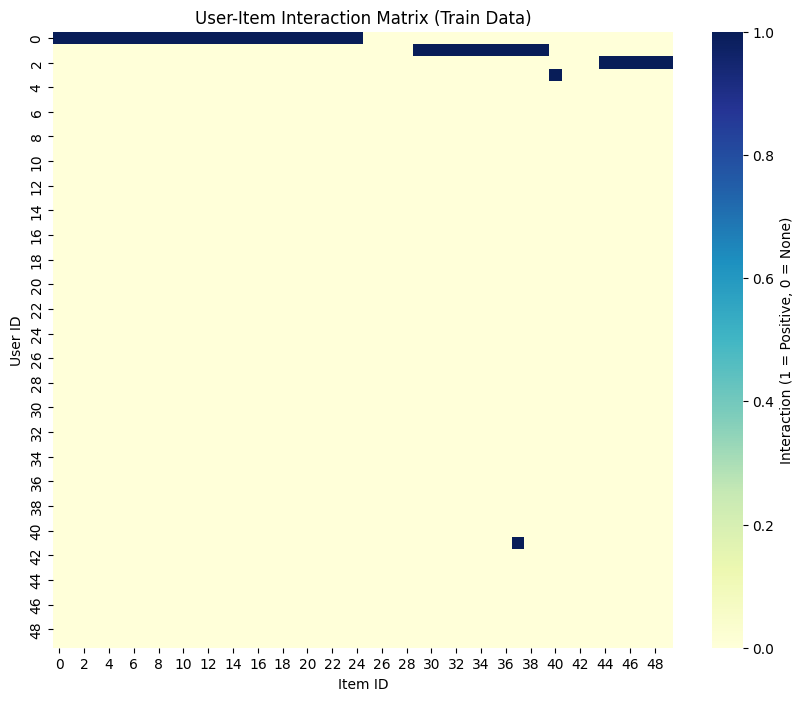

In [38]:
# Function to plot a heatmap for a subset of the user-item matrix
def plot_interaction_heatmap(data_matrix, title, num_users=50, num_items=50):
    """
    Plots a heatmap of a subset of the user-item interaction matrix.
    Parameters:
        data_matrix: The matrix to visualize.
        title: The title of the plot.
        num_users: The number of users to display (rows).
        num_items: The number of items to display (columns).
    """
    # Extract a subset of the matrix for visualization purposes
    matrix_subset = data_matrix[:num_users, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="YlGnBu", cbar=True, cbar_kws={'label': 'Interaction (1 = Positive, 0 = None)'})
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the training and testing matrices
plot_interaction_heatmap(train_data_matrix, 'User-Item Interaction Matrix (Train Data)')



## Task 3: Item-to-Item Collaborative Filtering with Implicit Feedback

Now that we’ve prepared our data, our next task is to create a recommender system using **Item-to-Item Collaborative Filtering**. In this context, the recommendation translates to “Users who liked this item (movie) also liked …”.

Since we’re working with implicit feedback, the prediction formula will focus on the **likelihood of positive interactions** rather than ratings. This will predict items the user may interact with based on similarities to items they’ve previously liked.

The following formula shows how to compute the likelihood of interaction between a user $u$ and item $i$ using item-to-item colaborative filtering.

\begin{equation}
{p}_{u}(i) =  \frac{\sum\limits_{i' \in I} \text{sim}(i, i') \cdot {R}_{u}(i')}{\sum\limits_{i' \in I} \text{sim}(i, i')}
\end{equation}

In the above formula:


*   $P_u(i)$ is the likelihood of user $u$ interacting with item $i$. This is the value we want to compute.
*   $\text{sim}(i, i')$ is the cosine similarity between items $i$ and $i'$.
*   $R_u(i')$ is one if user $u$ has already interacted with item $i'$. Otherwise it is zero.
*   $I$ is the set of all items in the dataset.

The value $P_u(i)$ is expected to be between 0 and 1.



#### Step 1: Compute Item Similarity Matrix

As a first step, we’ll calculate the pairwise similarity matrix between all items using **cosine similarity**. This matrix will show how similar each item is to every other item based on the interaction patterns of users. The output will be an `n_items` by `n_items` symmetric 2D numpy matrix.

In [39]:
# Compute the item-item similarity matrix
# Check sklearn documentation for cosine similarity to understand how we are
# using this function.
item_similarity = cosine_similarity(train_data_matrix.T)
print("Item-Item Similarity Matrix:")
print(item_similarity)
print(item_similarity.shape)


Item-Item Similarity Matrix:
[[1.         0.40824829 0.33333333 ... 0.         0.         0.        ]
 [0.40824829 1.         0.40824829 ... 0.         0.         0.        ]
 [0.33333333 0.40824829 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]
(15291, 15291)


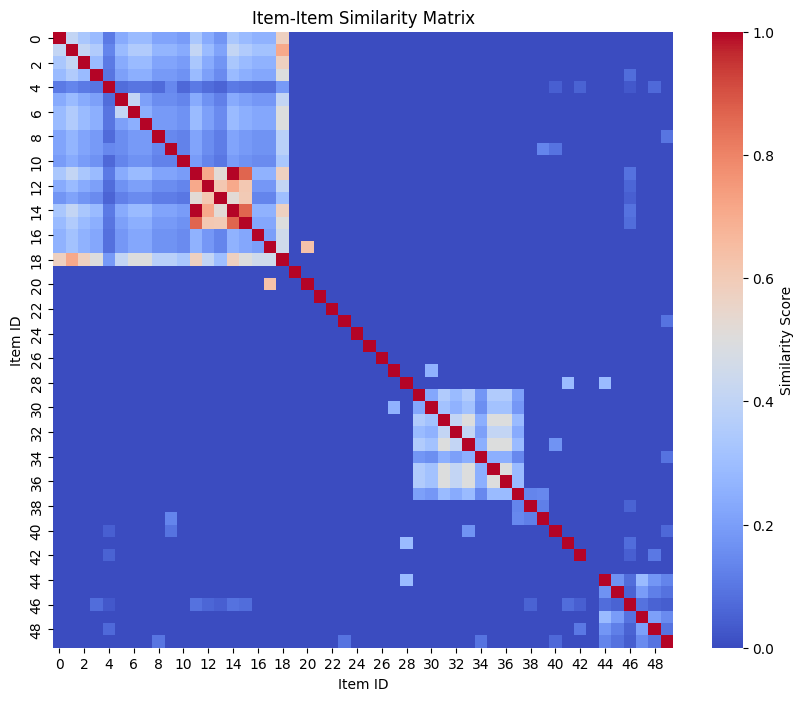

In [16]:
# Function to visualize the item similarity matrix
def plot_item_similarity_heatmap(similarity_matrix, title, num_items=50):
    """
    Plots a heatmap of a subset of the item similarity matrix.
    Parameters:
        similarity_matrix: The item-item similarity matrix.
        title: The title of the plot.
        num_items: The number of items to display (both rows and columns).
    """
    # Extract a subset of the matrix for visualization
    matrix_subset = similarity_matrix[:num_items, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="coolwarm", cbar=True, cbar_kws={'label': 'Similarity Score'})
    plt.xlabel('Item ID')
    plt.ylabel('Item ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the item similarity matrix
plot_item_similarity_heatmap(item_similarity, 'Item-Item Similarity Matrix')


Let's have a look at the 2 items that have a similarity of one [14 and 11] --> Have same user_id & timestamp

In [17]:
# comparison 14 & 11 from train_data get all entries w. book_id 14

# Display entries where book_id is 14 in the train_data DataFrame.
print(train_data[train_data['book_id'] == 14])

# Display entries where book_id is 14 in the train_data DataFrame.
print(train_data[train_data['book_id'] == 11])

       user_id  book_id     timestamp  pct_rank
15           0       14  1.693907e+09  0.600000
17661     1106       14  1.693905e+09  0.282209
17663     1106       14  1.693905e+09  0.294479
42768     2749       14  1.678371e+09  0.285714
       user_id  book_id     timestamp  pct_rank
12           0       11  1.693907e+09  0.520000
17660     1106       11  1.693905e+09  0.276074
17662     1106       11  1.693905e+09  0.288344
42767     2749       11  1.678371e+09  0.142857


#### Step 2: Predict Positive Interactions Using Item Similarity

Next, we’ll use the item similarity matrix to predict the likelihood of positive interactions for each user with each item.

In what follows, we create a function that implements the above formula for item-to-item cf recommendation.

In [40]:
# Define the function to predict interactions based on item similarity
def item_based_predict(interactions, similarity, epsilon=1e-9):
    """
    Predicts user-item interactions based on item-item similarity.
    Parameters:
        interactions (numpy array): The user-item interaction matrix.
        similarity (numpy array): The item-item similarity matrix.
        epsilon (float): Small constant added to the denominator to avoid division by zero.
    Returns:
        numpy array: The predicted interaction scores for each user-item pair.
    """
    # np.dot does the matrix multiplication. Here we are calculating the
    # weighted sum of interactions based on item similarity
    pred = similarity.dot(interactions.T) / (similarity.sum(axis=1)[:, np.newaxis] + epsilon)
    return pred.T  # Transpose to get users as rows and items as columns

# Calculate the item-based predictions for positive interactions
item_prediction = item_based_predict(train_data_matrix, item_similarity)
print("Predicted Interaction Matrix:")
print(item_prediction)
print(item_prediction.shape)

Predicted Interaction Matrix:
[[0.50330859 0.887555   0.72071387 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.02788041 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(7838, 15291)


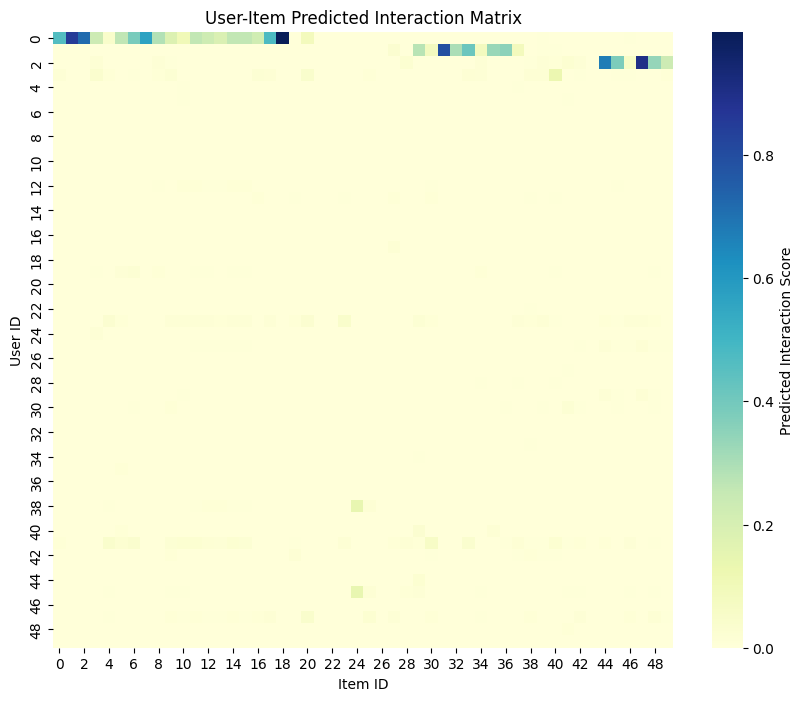

In [19]:
# Function to visualize the predicted interaction matrix for a subset of users and items
def plot_interaction_prediction_heatmap(prediction_matrix, title, num_users=50, num_items=50):
    """
    Plots a heatmap of a subset of the user-item predicted interaction matrix.
    Parameters:
        prediction_matrix: The predicted interaction matrix.
        title: The title of the plot.
        num_users: The number of users to display (rows).
        num_items: The number of items to display (columns).
    """
    # Extract a subset of the matrix for visualization
    matrix_subset = prediction_matrix[:num_users, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="YlGnBu", cbar=True, cbar_kws={'label': 'Predicted Interaction Score'})
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the predicted interaction matrix
plot_interaction_prediction_heatmap(item_prediction, 'User-Item Predicted Interaction Matrix')



In this setup:
- The `item_based_predict` function calculates a score for each user-item pair using the item-to-item colaborative filtering formula.
- The result is a prediction matrix where each cell indicates the predicted likelihood of an interaction between each user and item.

## Task 4: User-to-User Collaborative Filtering with Implicit Feedback

In this task, we’ll create a recommender system using **User-to-User Collaborative Filtering**. This approach translates to “Users who are similar to you also liked…”. We’ll predict the likelihood of a user interacting with an item based on the behavior of similar users.


#### Step 1: Compute User Similarity Matrix

To start, we’ll compute the similarity matrix between users using **cosine similarity**. This matrix shows how similar each user is to every other user based on their interaction patterns. This will create a `num_users * num_users` matrix.

In [41]:
# Compute the user-user similarity matrix
user_similarity = cosine_similarity(train_data_matrix)
print("User-User Similarity Matrix:")
print(user_similarity)

# Check the shape as a sanity check
print("Shape of User Similarity Matrix:", user_similarity.shape)


User-User Similarity Matrix:
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.08084521]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.08084521 ... 0.         0.         1.        ]]
Shape of User Similarity Matrix: (7838, 7838)


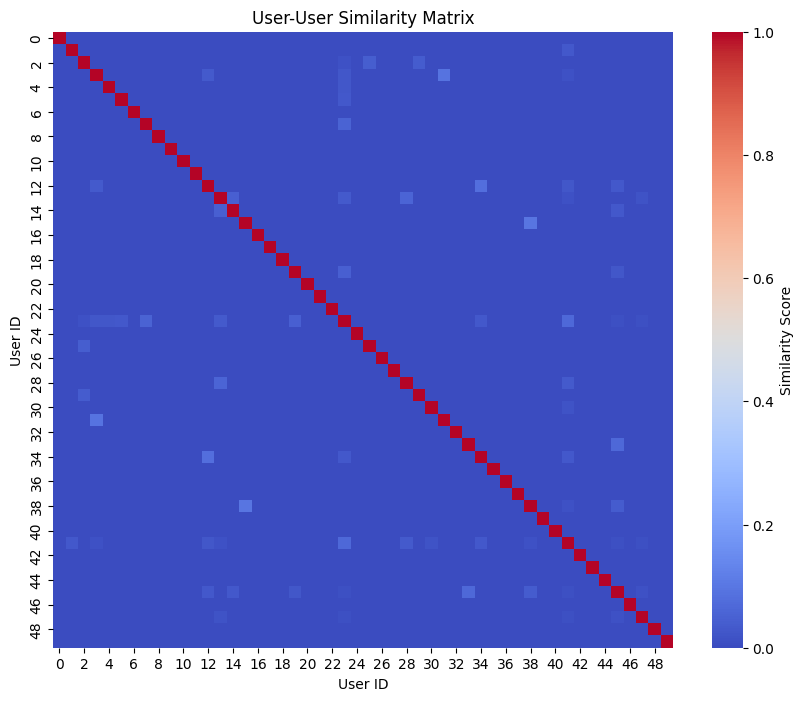

In [42]:
# Function to plot the user similarity matrix
def plot_user_similarity_heatmap(similarity_matrix, title, num_users=50):
    """
    Plots a heatmap of a subset of the user similarity matrix.
    Parameters:
        similarity_matrix: The user-user similarity matrix.
        title: The title of the plot.
        num_users: The number of users to display (both rows and columns).
    """
    # Extract a subset of the matrix for visualization
    matrix_subset = similarity_matrix[:num_users, :num_users]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="coolwarm", cbar=True, cbar_kws={'label': 'Similarity Score'})
    plt.xlabel('User ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the user similarity matrix
plot_user_similarity_heatmap(user_similarity, 'User-User Similarity Matrix')


### Step 2: Predict Positive Interactions Using User Similarity

Next, we’ll use the user similarity matrix to predict the likelihood of positive interactions for each user with each item. Since we’re working with implicit feedback, we’ll calculate a score for each item based on binary interaction values (1 for positive interactions, 0 for none).

The prediction formula is as follows:

\begin{equation}
{p}_{u}(i) = \frac{\sum\limits_{u' \in U} \text{sim}(u, u') \cdot {R}_{u'}(i)}{\sum\limits_{u' \in U} \text{sim}(u, u')}
\end{equation}


#### Explanation:
*   $P_u(i)$ is the likelihood of user $u$ interacting with item $i$. This is the value we want to compute.
*   $\text{sim}(u, u')$ is the cosine similarity between users $u$ and $u'$.
*   $R_u'(i)$ is one if user $u'$ has already interacted with item $i$. Otherwise it is zero.
*   $U$ is the set of all users in the dataset.


This formula calculates the likelihood of interaction between user $ u $ and item $ i $ based on interactions of similar users with that item. The weighted sum of interactions from similar users is normalized by the sum of the similarities.

- **`similarity.dot(interactions)`**: Calculates the weighted sum of interactions for each user, based on similar users’ interactions.
- **`np.abs(similarity).sum(axis=1)[:, np.newaxis]`**: The denominator normalizes the prediction by the sum of absolute similarities to avoid bias from users with more neighbors.
- **`epsilon`**: Prevents division by zero, which could result in `NaN` values.

In [43]:
# Define the function to predict interactions based on user similarity
def user_based_predict(interactions, similarity, epsilon=1e-9):
    """
    Predicts user-item interactions based on user-user similarity.
    Parameters:
        interactions (numpy array): The user-item interaction matrix.
        similarity (numpy array): The user-user similarity matrix.
        epsilon (float): Small constant added to the denominator to avoid division by zero.
    Returns:
        numpy array: The predicted interaction scores for each user-item pair.
    """
    # Calculate the weighted sum of interactions based on user similarity
    pred = similarity.dot(interactions) / (np.abs(similarity).sum(axis=1)[:, np.newaxis] + epsilon)
    return pred

# Calculate the user-based predictions for positive interactions
user_prediction = user_based_predict(train_data_matrix, user_similarity)
print("Predicted Interaction Matrix (User-Based):")
print(user_prediction)
print(user_prediction.shape)


Predicted Interaction Matrix (User-Based):
[[0.12083887 0.12253831 0.12798326 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00421191 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(7838, 15291)


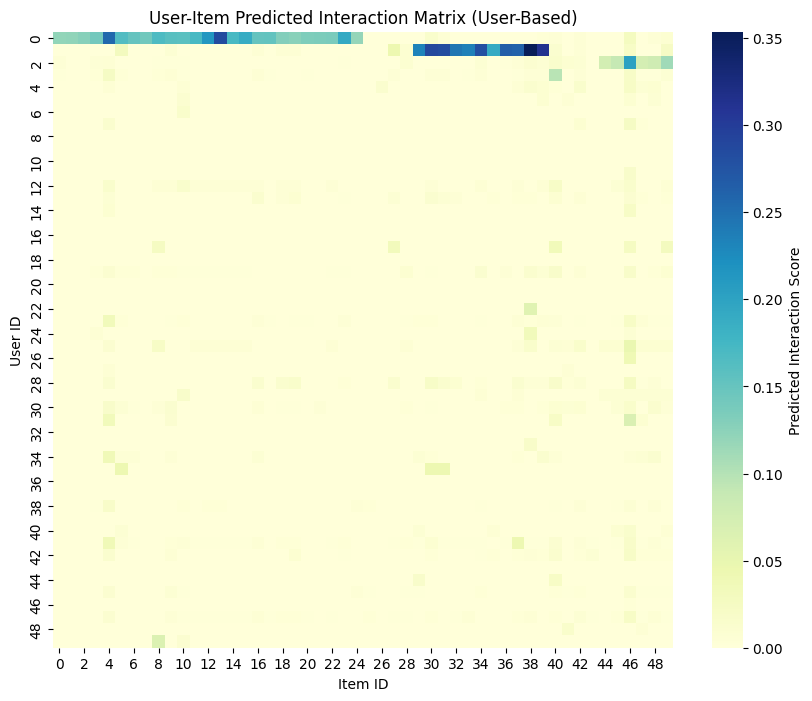

In [44]:
# Function to visualize the predicted interaction matrix for a subset of users and items
def plot_interaction_prediction_heatmap(prediction_matrix, title, num_users=50, num_items=50):
    """
    Plots a heatmap of a subset of the user-item predicted interaction matrix.
    Parameters:
        prediction_matrix: The predicted interaction matrix.
        title: The title of the plot.
        num_users: The number of users to display (rows).
        num_items: The number of items to display (columns).
    """
    # Extract a subset of the matrix for visualization
    matrix_subset = prediction_matrix[:num_users, :num_items]

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix_subset, cmap="YlGnBu", cbar=True, cbar_kws={'label': 'Predicted Interaction Score'})
    plt.xlabel('Item ID')
    plt.ylabel('User ID')
    plt.title(title)
    plt.show()

# Visualize a subset of the predicted interaction matrix
plot_interaction_prediction_heatmap(user_prediction, 'User-Item Predicted Interaction Matrix (User-Based)')


## Task 5: Evaluating Our Recommenders

#### Ranking Accurarcy (Precision@K and Recall@K)

An implicit recommendation system is a ranking system which ranks items for each user based on their relevance to the user. Therefore, to evaluate such system, we’re interested in the quality of the top ranked recommendations rather than the actual predicted score for each recommendation. **Precision@K** and **Recall@K** focus on the top-K items recommended for each user, measuring relevance of the top-ranked recommended items to a user.

- **Precision@K**: Measures the proportion of relevant items in the top-K recommendations.
  
  \begin{equation}
  \text{Precision@K} = \frac{\text{Number of relevant items in top-K}}{K}
  \end{equation}

- **Recall@K**: Measures the proportion of actual relevant items that appear in the top-K recommendations.

  \begin{equation}
  \text{Recall@K} = \frac{\text{Number of relevant items in top-K}}{\text{Total number of relevant items}}
  \end{equation}

Recall@k and Precision@k are metrics that are computed per user. To have a single value to evaluate a recommender system as a whole, we can take the average of Recall@K and Precision@K among all of the users.

### Your Turn !

As an exercise, complete the function precision_recall_at_k below to calculate Precision@K and Recall@K for a given value of K. Follow the instructions provided in the function to fill in the missing parts.

In [24]:
# Implement the precision_recall_at_k function
def precision_recall_at_k(prediction, ground_truth, k=10):
    """
    Calculates Precision@K and Recall@K for top-K recommendations.
    Parameters:
        prediction (numpy array): The predicted interaction matrix with scores.
        ground_truth (numpy array): The ground truth interaction matrix (binary).
        k (int): Number of top recommendations to consider.
    Returns:
        precision_at_k (float): The average precision@K over all users.
        recall_at_k (float): The average recall@K over all users.
    """
    num_users = prediction.shape[0]
    precision_at_k, recall_at_k = 0, 0

    for user in range(num_users):
        # TODO: Get the indices of the top-K items for the user based on predicted scores
        top_k_items = np.argsort(prediction[user, :])[-k:]

        # TODO: Calculate the number of relevant items in the top-K items for the user
        relevant_items_in_top_k = np.isin(top_k_items, np.where(ground_truth[user, :] == 1)[0]).sum()

        # TODO: Calculate the total number of relevant items for the user
        total_relevant_items = ground_truth[user, :].sum()

        # Precision@K and Recall@K for this user
        precision_at_k += relevant_items_in_top_k / k
        recall_at_k += relevant_items_in_top_k / total_relevant_items if total_relevant_items > 0 else 0

    # Average Precision@K and Recall@K over all users
    precision_at_k /= num_users
    recall_at_k /= num_users

    return precision_at_k, recall_at_k


After completing the function, you can calculate Precision@K and Recall@K for the user-based and item-based predictions as follows:



In [25]:
# Run this line after implementing the function
precision_user_k, recall_user_k = precision_recall_at_k(user_prediction, test_data_matrix, k=10)
precision_item_k, recall_item_k = precision_recall_at_k(item_prediction, test_data_matrix, k=10)

print('User-based CF Precision@K:', precision_user_k)
print('User-based CF Recall@K:', recall_user_k)
print('Item-based CF Precision@K:', precision_item_k)
print('Item-based CF Recall@K:', recall_item_k)


User-based CF Precision@K: 0.0565577953559609
User-based CF Recall@K: 0.2906756989169525
Item-based CF Precision@K: 0.05567746874202883
Item-based CF Recall@K: 0.26399850355796506


## Task 6: Show the Recommendations for a Specific User

Pick a user at random. Extract the top-10 recommendations for this user by both the User-to-User and Item-to-Item Collaborative Filtering models. Present the recommendations by showing the movie posters.

__Hint:__ You can get the movie posters from the TMDb API. In the `links` DataFrame, you’ll find the TMDb ID corresponding to each movie. Using this ID, retrieve the movie poster and display it.

### Step 6.1: Select a User and Get Recommendations

Start by selecting a user at random, and then extract the top-10 recommended movies for that user from both the User-to-User and Item-to-Item models.

In [26]:
# Pick a user at random
user_id = random.choice(range(user_prediction.shape[0]))
print("Selected User ID:", user_id)

# Get top-10 recommendations for the user from User-to-User CF
user_top_10 = np.argsort(user_prediction[user_id, :])[-10:][::-1]

# Get top-10 recommendations for the user from Item-to-Item CF
item_top_10 = np.argsort(item_prediction[user_id, :])[-10:][::-1]

# Display top-10 recommended movie IDs for both models
display(user_top_10)
display(item_top_10)

Selected User ID: 1076


array([1532,  404, 3465, 1166, 8830, 2742, 2820, 8828, 1165, 8832])

array([8833, 8827, 8826, 8732, 8832, 8828, 8829, 8831, 3779, 8830])

In [46]:
def create_recommendation_table(user_predictions, top_n=10, separator=" "):
    """
    Creates a table of top-N recommendations for each user.

    Args:
        user_predictions (numpy.ndarray): Rows = users, columns = items. Predicted scores.
        top_n (int): Number of top recommendations per user.
        separator (str): Delimiter to join recommended book IDs.

    Returns:
        pandas.DataFrame: Columns = ['user_id', 'recommendation'].
    """
    recommendations = []
    num_users = user_predictions.shape[0]

    for user_id in range(num_users):
        top_items = np.argsort(user_predictions[user_id, :])[-top_n:][::-1]
        recommendations.append({
            'user_id': user_id,
            'recommendation': separator.join(map(str, top_items))
        })

    return pd.DataFrame(recommendations)

# Example usage with space-separated book_ids
user_recommendations_df = create_recommendation_table(user_prediction, top_n=10, separator=" ")
item_recommendations_df = create_recommendation_table(item_prediction, top_n=10, separator=" ")

# Save and display
user_recommendations_df.to_csv('user_recommendations.csv', index=False)
item_recommendations_df.to_csv('item_recommendations.csv', index=False)

print("User-based Recommendations:")
display(user_recommendations_df)

print("\nItem-based Recommendations:")
display(item_recommendations_df)

User-based Recommendations:


,user_id,recommendation
0,0,13 4 12 23 15 11 14 8 5 9
1,1,38 39 30 31 34 36 37 32 33 29
2,2,46 58 49 56 53 91 64 87 45 71
3,3,149 169 163 167 128 133 143 40 139 165
4,4,203 198 207 205 195 202 193 191 199 201
...,...,...
7833,7833,7760 975 7322 7306 611 9610 1130 8086 2350 6560
7834,7834,1367 13891 7128 8999 15276 3055 101 2125 10651...
7835,7835,3055 6791 4820 11126 8369 8999 9719 53 1367 15062
7836,7836,3471 14550 14552 611 15065 3470 8999 618 14557...



Item-based Recommendations:


,user_id,recommendation
0,0,1 24 21 2 20 0 17 7 6 11
1,1,31 33 35 29 13434 32 36 2988 6003 12857
2,2,94 80 92 76 50 52 72 79 57 59
3,3,157 132 145 134 140 116 155 162 151 168
4,4,192 204 202 200 203 191 194 205 196 195
...,...,...
7833,7833,12575 7322 10460 5121 975 7760 5122 1978 13458...
7834,7834,15276 13890 7128 13891 15255 2154 15226 13808 ...
7835,7835,4820 6317 13626 9957 4061 14875 3055 14471 147...
7836,7836,15065 14550 14619 15184 14560 14092 14618 1182...


### Step 6.2: Create Recommendation DataFrames

Merge the recommendations with the `item` and DataFrames to create two DataFrames (`user_recommendations_df` and `item_recommendations_df`) with columns `book_id`, `title`


In [28]:
# Convert user_top_10 and item_top_10 arrays into DataFrames
user_top_10_df = pd.DataFrame({'book_id': user_top_10})
item_top_10_df = pd.DataFrame({'book_id': item_top_10})

# Merge with items_df to add the title column
user_recommendations_df = user_top_10_df.merge(items[['book_id', 'Title']], left_on='book_id', right_on='book_id')
item_recommendations_df = item_top_10_df.merge(items[['book_id', 'Title']], left_on='book_id', right_on='book_id')

# Select only the columns we want to display
user_recommendations_df = user_recommendations_df[['book_id', 'Title']]
item_recommendations_df = item_recommendations_df[['book_id', 'Title']]

# Display the results
display(user_recommendations_df)
display(item_recommendations_df)

,book_id,Title
0,1532,Evaluation clinique d'une personne symptomatiq...
1,404,Soins infirmiers en périnatalité /
2,3465,La pensée infirmière /
3,1166,Soins infirmiers en pédiatrie /
4,8830,Diabéto : l'infirmière en diabétologie /
5,2742,Diagnostics infirmiers : définitions et classi...
6,2820,Soins infirmiers : médecine et chirurgie /
7,8828,Le calcul de doses sans erreur /
8,1165,Diagnostics infirmiers : interventions et just...
9,8832,Alzheimer et autres formes de démence : guide ...


,book_id,Title
0,8833,L'agression sexuelle envers les enfants /
1,8827,Calculs de dose UE 4.4 : exercices corrigés /
2,8826,Ethique et soins infirmiers /
3,8732,Les âges de la vie : psychologie du développem...
4,8832,Alzheimer et autres formes de démence : guide ...
5,8828,Le calcul de doses sans erreur /
6,8829,"Le diabète : mieux connaître, mieux comprendre..."
7,8831,Mémento 100% visuel des pathologies en IFSI /
8,3779,"Prendre soin, care et caring : des voies diffé..."
9,8830,Diabéto : l'infirmière en diabétologie /


### Fetching and Displaying Movie Posters

The following code uses the **TMDb API** to fetch movie posters based on the `tmdbId` of each recommended movie. The `fetch_poster` function retrieves the movie poster URL, and the `show_recommendations` function displays the posters for the top-10 recommendations.

You’ll use these functions in the next step to display the movie recommendations for a specific user.

In [29]:
%pip install tmdbv3api

In [30]:
from tmdbv3api import TMDb, Movie
import pandas as pd

# Set up the TMDb API with your API key
tmdb = TMDb()
tmdb.api_key = '37117cc09d5e00673f14f1cb7c7468b2'  # Replace with your actual TMDb API key

movie_api = Movie()

# Function to fetch movie posters
def fetch_poster(tmdb_id):
    try:
        details = movie_api.details(tmdb_id)
        poster_path = details.poster_path
        return f"https://image.tmdb.org/t/p/w200{poster_path}" if poster_path else None
    except:
        return None

#### Displaying Movie Posters for Top-10 Recommendations

In this step, you’ll complete the `show_recommendations` function to display the movie posters for the top-10 recommendations for a specific user, using the `tmdbId` from the `links` DataFrame.

1. **Fetch the `tmdbId`** for each movie in the recommendations:
   - Use the `links` DataFrame to retrieve the `tmdbId` for each recommended `movie_id`.
   - This `tmdbId` is then used to fetch the poster image via the TMDb API.

2. **Fetch and Display the Poster Image**:
   - Use the `fetch_poster` function (already defined) to get the poster URL based on the `tmdbId`.
   - If the poster URL is available, retrieve the image using the `requests` library and display it in the subplot.
   - If no poster is available, show a "No Image" placeholder text.

Here’s the code with placeholders where you need to complete each step:

NameError: name 'links' is not defined

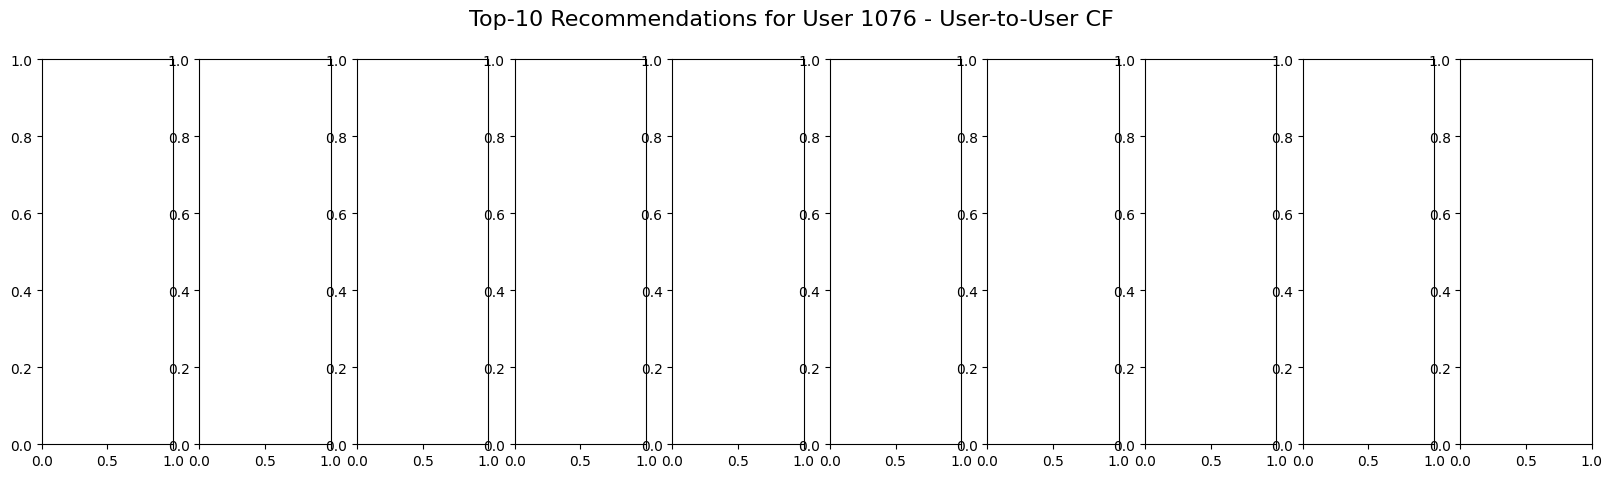

In [31]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

def show_recommendations(recommendations, model_name):
    """
    Displays the movie posters for the top-10 recommended movies.

    Parameters:
    - recommendations: List or array of recommended movie IDs.
    - model_name: Name of the recommendation model (e.g., "User-to-User CF" or "Item-to-Item CF").
    """
    fig, axes = plt.subplots(1, len(recommendations), figsize=(20, 5))
    fig.suptitle(f"Top-10 Recommendations for User {user_id} - {model_name}", fontsize=16)

    for i, movie_id in enumerate(recommendations):
        # Step 1: Fetch the `tmdbId` for the movie from the `links` DataFrame
        # - Use `movie_id` to locate the corresponding `tmdbId`
        # - Ensure `tmdb_id` is extracted as an integer
        tmdb_id = links.loc[links['movie_id'] == movie_id, 'tmdbId'].values
        if len(tmdb_id) == 0:
            axes[i].axis('off')
            continue

        # Step 2: Fetch the poster URL using the `fetch_poster` function
        # - Pass `tmdb_id[0]` to `fetch_poster` and store the result in `poster_url`
        poster_url = fetch_poster(int(tmdb_id[0]))

        # Step 3: Display the poster image if available
        # - If `poster_url` is valid, use `requests` to get the image and display it
        # - If `poster_url` is None, display "No Image" text in the placeholder
        if poster_url:
            response = requests.get(poster_url)
            img = Image.open(BytesIO(response.content))
            axes[i].imshow(img)
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, "No Image", ha='center', va='center')
            axes[i].axis('off')

    plt.show()

# Example usage after completing the TODOs:
# Display top-10 recommendations for User-to-User CF
show_recommendations(user_top_10, "User-to-User CF")

# Display top-10 recommendations for Item-to-Item CF
show_recommendations(item_top_10, "Item-to-Item CF")